In [44]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import glob
import shutil
import matplotlib.image as mpimg
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from datetime import time
from datetime import datetime

from google.cloud import bigquery

import shap
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
import re
import catboost as cb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization
from scipy.stats import uniform

from pandas_profiling import ProfileReport

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
#read data and load into pandas dataframe

sheetname='data (5)'
df = pd.read_excel(r'./sample_files/data (5).xlsx', sheet_name=sheetname)
experiment = "experiment_2"

In [3]:
df.head()

,Unnamed: 0,ces,claim_number,services_used,line_of_business,auto_damage_severity,digital_claim_ind,loss_cause,emergency_transport_used,insured_fault_pct,...,loss_reported_to_assignment_days,assignment_sent_to_retrieved_days,estimate_start_to_estimate_complete_days,first_supplement_to_last_supplement_days,tl_valuation_request_return_days,original_effective_datetime,repair_cost_to_regional_value_pct,regional_value_amt,ehidailyvehicleamount,ehinumberofdays
0,0,2.0,01-003-845063,"Service Request Proxy,SCHAEFER AUTOBODY CENTER...",Personal Auto Line,Repairable,0.0,Theft,NaN,0.0,...,2.52,0.06,0.02,0.0,0.00,2016-06-07,5.00,16891.0,NaN,NaN
1,1,7.0,01-003-941543,Service Request Proxy,Personal Auto Line,Repairable,0.0,Theft,NaN,0.0,...,2.66,0.11,0.00,0.0,0.00,2016-08-05,35.86,8013.0,NaN,NaN
2,2,5.0,01-003-977434,NaN,Personal Auto Line,Repairable,0.0,Collision with Stationary/Other Object,NaN,0.0,...,0.63,0.07,0.03,0.0,0.00,2015-04-21,11.43,11760.0,NaN,NaN
3,3,1.0,01-003-823419,"Enterprise Holdings,Service Request Proxy",Personal Auto Line,Total Loss,0.0,Theft,NaN,0.0,...,27.63,0.00,0.21,0.0,0.21,2021-05-22,37.76,5645.0,NaN,NaN
4,4,7.0,01-004-649502,"Virtual Proxy,Fabric",Personal Auto Line,Repairable,0.0,Collision with Motor Vehicle/Watercraft,NaN,100.0,...,13.26,0.04,0.09,0.0,0.00,2006-06-30,25.34,7625.0,NaN,NaN


In [4]:
#Create copy of dataframe, add in random numerical column and drop any irrelevant features

df_copy = df.copy()
df_copy['random_num_col_should_drop_from_model']= np.random.randint(0,1000,size=(len(df_copy),1))

df_copy.drop(['claim_number', 'Unnamed: 0'], axis=1, inplace=True) 

In [5]:
#Create Target Indicator DF and drop indicator from main df

df_copy = df_copy.dropna(axis=0, subset=['ces'])
y = df_copy.ces
df_copy.drop(['ces'], axis=1, inplace=True)

# DateTime Preprocessing and Feature Engineering

SKLearn cannot handle DateTime Data Types and as such need to be preprocessed in order to convert these into useful numerical/categorical features through Feature Engineering

In [6]:
mask = df_copy.astype(str).apply(lambda x : x.str.match(r'\d{4}-\d{2}-\d{2}').any())
df_copy.loc[:,mask] = df_copy.loc[:,mask].apply(pd.to_datetime, errors='coerce')
mask

services_used                               False
line_of_business                            False
auto_damage_severity                        False
digital_claim_ind                           False
loss_cause                                  False
emergency_transport_used                    False
insured_fault_pct                           False
adjuster_group                              False
injury_incident_ind                         False
number_of_vehicles_on_claim                 False
paid_loss_amount                            False
reserve_loss_amount                         False
auto_method_of_inspection                   False
fnol                                         True
days_fnol_to_first_close                    False
dateofbirth                                  True
deductible_amt                              False
reported_by                                 False
labor_hrs                                   False
vehicle_age                                 False


In [7]:
datetime_cols = [cname for cname in df_copy.columns if 
                    df_copy[cname].dtype == "datetime64[ns]"]

df_dt = df_copy[datetime_cols]

for col in df_dt.columns:
    df_copy["%s_ScheduledDay_year" %(col)] = df_dt[col].dt.year
    df_copy["%s_ScheduledDay_month" %(col)] = df_dt[col].dt.month
    df_copy["%s_ScheduledDay_day" %(col)] = df_dt[col].dt.day
    df_copy["%s_ScheduledDay_week" %(col)] = df_dt[col].dt.isocalendar().week 
    df_copy["%s_ScheduledDay_weekday" %(col)] = df_dt[col].dt.weekday
    df_copy["%s_ScheduledDay_dayofyear" %(col)] = df_dt[col].dt.dayofyear
    df_copy["%s_ScheduledDay_month_start" %(col)] = df_dt[col].dt.is_month_start
    df_copy["%s_ScheduledDay_month_end" %(col)] = df_dt[col].dt.is_month_end
    df_copy["%s_ScheduledDay_quarter_start" %(col)] = df_dt[col].dt.is_quarter_start
    df_copy["%s_ScheduledDay_quarter_end" %(col)] = df_dt[col].dt.is_quarter_end
    df_copy["%s_ScheduledDay_year_start" %(col)] = df_dt[col].dt.is_year_start
    df_copy["%s_ScheduledDay_year_end" %(col)] = df_dt[col].dt.is_year_end
    df_copy["%s_ScheduledDay_leap_year" %(col)] = df_dt[col].dt.is_leap_year
    df_copy["%s_ScheduledDay_daysinmonth" %(col)] = df_dt[col].dt.daysinmonth
    
df_copy = df_copy.drop(columns=df_copy.select_dtypes(['datetime']).columns)

# Impute Numerical Features and Encode Categorical Features

In [8]:
X_full = df_copy.copy()

numerical_cols = [cname for cname in X_full.columns if 
                X_full[cname].dtype in ['int64', 'float64']]

X_full_n = X_full.select_dtypes(['int64', 'float64']).fillna(-9999)

In [9]:
categorical_cols = [cname for cname in X_full.columns if
                    X_full[cname].nunique() < 30 and 
                    X_full[cname].dtype == "object"]

In [10]:
X_full_c = X_full[categorical_cols]

X_full_c = pd.get_dummies(
    data = X_full_c,
    dummy_na=True
)

In [11]:
X_full = pd.merge(X_full_n, X_full_c, left_index=True, right_index=True)

In [12]:
X_full.isnull().values.any()

False

# Check for MultiCollinear Features and Manually Remove

In [13]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_full[numerical_cols].columns
vif_data["VIF"] = [variance_inflation_factor(X_full[numerical_cols].values, i) for i in range(len(X_full[numerical_cols].columns))]

In [14]:
#display(vif_data)

In [15]:
vif_data_feats_drop = vif_data.loc[~(vif_data['VIF'] < 10)]
drop = [fname for fname in vif_data['feature'].values]
#drop

In [16]:
#Select Features to drop based on above list

#X_full.drop([drop], axis=1, inplace=True)


In [17]:
count = np.isinf(y).values.sum()
na = y.isnull().values.any()
print("It contains " + str(count) + " infinite values")
print(na)

It contains 0 infinite values
False


In [18]:
#Check for Infinity, NA values and values too large for float64 dtypes

X_full =X_full[~X_full.isin([np.nan, np.inf, -np.inf]).any(1)]
count = np.isinf(X_full).values.sum()
na = X_full.isnull().values.any()
print("It contains " + str(count) + " infinite values")
print(na)

It contains 0 infinite values
False


# Fit & Predict Naive/Tree/Boosted Models 

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.75, test_size=0.25,
                                                                random_state=0)



In [20]:
#Train Naive Model - Establish Baseline

model = LinearRegression().fit(X_train, y_train)
preds_n = model.predict(X_valid)
preds1_naive = np.round_(preds_n, decimals=0)

n_mse = mean_squared_error(y_valid, preds1_naive)
n_lin_rmse = np.sqrt(mean_squared_error(y_valid, preds1_naive))
n_mae = mean_absolute_error(y_valid, preds1_naive)
#nt_mse = mean_squared_error(y_train, X_train)
#nt_lin_rmse = np.sqrt(mean_squared_error(y_train, X_train))
#nt_mae = mean_absolute_error(y_train, X_train)

df_error_metrics = pd.DataFrame()
df_error_metrics['model_name'] = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Extra Trees', 'AdaBoost', 'LGBM', 'CatBoost']
df_error_metrics['RMSE'] = [n_lin_rmse, '0','0','0','0','0','0']
df_error_metrics['MAE'] = [n_mae,'0','0','0','0','0', '0']
df_error_metrics['MSE'] = [n_mse,'0','0','0','0','0', '0']
#df_error_metrics['RMSE_Training'] = [nt_lin_rmse, '0','0','0','0','0','0']
#df_error_metrics['MAE_Training'] = [nt_mae,'0','0','0','0','0', '0']
#df_error_metrics['MSE_Training'] = [nt_mse,'0','0','0','0','0', '0']
df_error_metrics

,model_name,RMSE,MAE,MSE
0,Logistic Regression,2.38651,1.181032,5.69543
1,Random Forest,0,0,0
2,XGBoost,0,0,0
3,Extra Trees,0,0,0
4,AdaBoost,0,0,0
5,LGBM,0,0,0
6,CatBoost,0,0,0


In [21]:
model1 = RandomForestRegressor(verbose=False)
model2 = XGBRegressor()
model3 = ExtraTreesRegressor()
model4 = AdaBoostRegressor()
model5 = LGBMRegressor()
X_train_5 = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
model6 = cb.CatBoostRegressor(silent=True)

model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)
model4.fit(X_train, y_train)
model5.fit(X_train_5, y_train)
model6.fit(X_train, y_train)

rf_prediction = model1.predict(X_valid)
xgboost_prediction = model2.predict(X_valid)
et_prediction = model3.predict(X_valid)
adaboost_prediction = model4.predict(X_valid)
LGBM_prediction = model5.predict(X_valid)
catboost_prediction = model6.predict(X_valid)

model_dict = {
    'Random Forest': model1, 
    'XGBoost': model2, 
    'Extra Trees': model3, 
    'AdaBoost': model4, 
    'LightGBM': model5, 
    'CatBoost': model6
}

# Create or Re-Create Directories

In [22]:
dir = experiment
if os.path.exists(dir):
    shutil.rmtree(dir)
try:
    os.makedirs(os.path.join('experiments',dir, 'baseline_models'))
except:
    shutil.rmtree(os.path.join('experiments', dir, 'baseline_models'))
    os.makedirs(os.path.join('experiments',dir, 'baseline_models'))
try:
    os.makedirs(os.path.join('experiments',dir, 'feature_importance_plots'))
except:
    shutil.rmtree(os.path.join('experiments', dir, 'feature_importance_plots'))
    os.makedirs(os.path.join('experiments',dir, 'feature_importance_plots'))

# Run Validation Tests & Generate Error Metrics

In [23]:
i=1
pred_dict = {
    'Random Forest': rf_prediction, 
    'XGBoost': xgboost_prediction, 
    'Extra Trees': et_prediction, 
    'AdaBoost': adaboost_prediction, 
    'LightGBM': LGBM_prediction, 
    'CatBoost': catboost_prediction
}

for pred in pred_dict:
    try:
        preds_n = np.round_(pred_dict[pred], decimals=0)
        v_mse = mean_squared_error(y_valid, pred_dict[pred])
        v_rmse = np.sqrt(mean_squared_error(y_valid, pred_dict[pred]))
        v_mae = mean_absolute_error(y_valid, pred_dict[pred])
        df_error_metrics.loc[i, 'RMSE'] = [v_rmse]
        df_error_metrics.loc[i, 'MAE'] = [v_mae]
        df_error_metrics.loc[i, 'MSE'] = [v_mse]
        i +=1
    except:
        pass
    
df_error_metrics.to_csv('./experiments/%s/baseline_models/baseline_model_scores.csv' %(experiment))
df_error_metrics.sort_values('MAE')

,model_name,RMSE,MAE,MSE
6,CatBoost,1.605565,1.111735,2.577837
5,LGBM,1.604514,1.112811,2.574465
2,XGBoost,1.641694,1.126335,2.695159
4,AdaBoost,1.633022,1.139974,2.666759
1,Random Forest,1.662414,1.177828,2.763621
0,Logistic Regression,2.38651,1.181032,5.69543
3,Extra Trees,1.742883,1.199264,3.037642


In [24]:
selected_models = [model1, model2]

# Select Models - Learning Curve Plots 

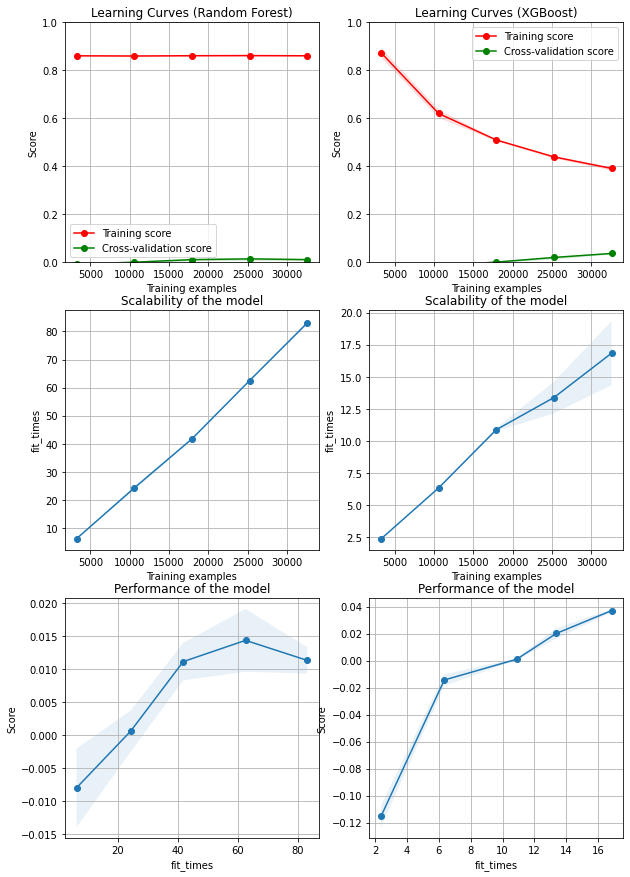

In [33]:
%matplotlib inline

fig, axes = plt.subplots(3, 2, figsize=(10, 15))
title = "Learning Curves (Random Forest)"
    
cv = ShuffleSplit(n_splits=2, test_size=0.2, random_state=0)

plot_learning_curve(
    model1, title, X_full, y, axes=axes[:, 0], ylim=(0, 1), cv=cv, n_jobs=4
)

title = r"Learning Curves (XGBoost)"

cv = ShuffleSplit(n_splits=2, test_size=0.2, random_state=0)

plot_learning_curve(
    model2, title, X_full, y, axes=axes[:, 1], ylim=(0, 1), cv=cv, n_jobs=4
)

plt.show()

# Model Selection

In [40]:
#Drop Models where Error Metrics are higher then Naive Model (Based on MAE)
#model1, model2, model3, model4, model5, model6
#models_for_fi = [model2]
models_forfi ={
    "XGBoost": model2
}

# Feature Importance

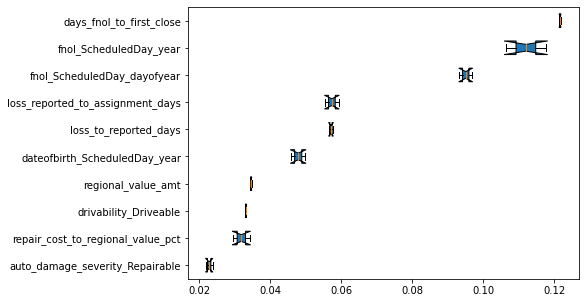

In [42]:
for key, value in models_forfi.items():    
    result = permutation_importance(value, X_valid, y_valid, n_repeats=2, random_state=42, scoring='neg_mean_absolute_error')
    perm_sorted_idx = pd.Series(result.importances_mean.argsort(), index=X_train.columns)
    ten_large = perm_sorted_idx[-10: ]
    fig = plt.figure(figsize =(7, 5))
    ax = fig.add_subplot(111)
    ax.boxplot(
        result.importances[ten_large].T,
        vert=False,
        patch_artist = True,
        notch = 'True',
        labels=X_train.columns[ten_large],
    )
    plt.savefig('./experiments/%s/feature_importance_plots/perm_feature_importance %s.png' %(experiment,key))
plt.show()

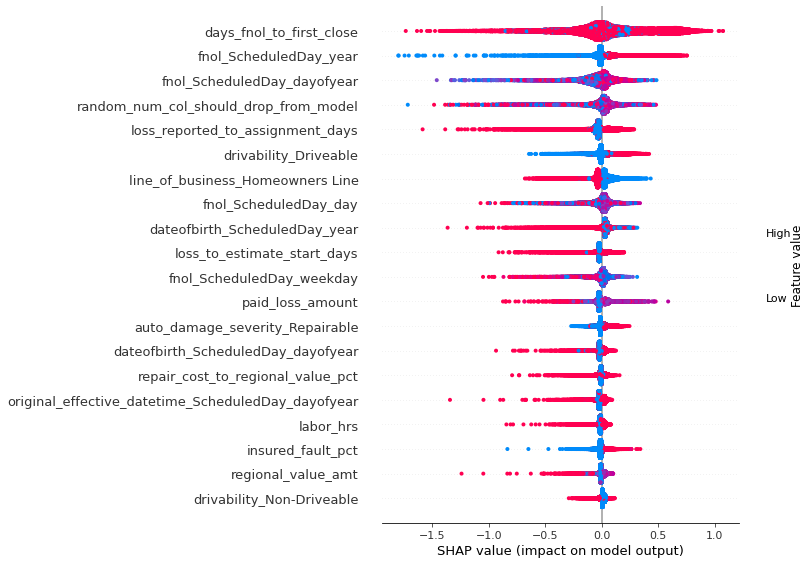

<Figure size 432x288 with 0 Axes>

In [32]:
for model in models_for_fi: 
    pyplot.clf()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    shap.summary_plot(shap_values, X_train)
    f = pyplot.figure()
    #f.savefig("./experiments/%s/feature_importance_plots/summary_shap %s.png" %(experiment, model))